# **Using a Physics-Informed Neural Network (PINN) to Solve a System fo Ordinary Differential Equations**

In this illustration, we propose to solve the following system of ODEs:

$$
\left\{
\begin{array}{rcl}
\frac{dx}{dt} &=& x - 2y \\
\frac{dy}{dt} &=& x - y \\
\end{array}
\right.
\quad \text{with Initial Conditions: } x(0) = 1, \; y(0) = 1
$$

- The exact solution is:

$$
x(t) = \cos{t} − \sin{t},  y(t) = \cos{t}
$$

## **PINN Solution Overview**

Instead of solving this system analytically or with traditional numerical solvers, we will train a neural network $\hat{x}(t)$, $\hat{y}(t)$ to approximate the solution. The network is trained by minimizing a loss function that enforces:

1. The ODE residuals: how well the network's predictions satisfy the differential equations.

2. The initial conditions: how close the predictions are to known initial values at $t=0$.


## **1. Define the Model**

W define a simple feedforward neural network:

- Input: scalar time $t$

- Output: 2D vector $[\hat{x}(t), \hat{y}(t)]$

- Architecture: 2 hidden layers with $\tanh$ activation

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set float precision
tf.keras.backend.set_floatx('float64')

# Define the PINN model
inputs = tf.keras.Input(shape=(1,), dtype=tf.float64)
x = tf.keras.layers.Dense(128, activation='tanh', dtype=tf.float64)(inputs)
x = tf.keras.layers.Dense(64, activation='tanh', dtype=tf.float64)(x)
outputs = tf.keras.layers.Dense(2, dtype=tf.float64)(x)  # output: [x(t), y(t)]
model = tf.keras.Model(inputs=inputs, outputs=outputs)

## **2. Compute the Residuals**

These enforce the physics: we use automatic differentiation to compute $\frac{d\hat{x}}{dt}$ and $\frac{d\hat{y}}{dt}$, then compare them with the right-hand sides of the ODE system.

- Residual 1: $\frac{d\hat{x}}{dt} - (\hat{x} - 2\hat{y})$ 

- Residual 2: $\frac{d\hat{y}}{dt} - (\hat{x} - \hat{y})$

In [9]:
# Compute residuals of the ODE system
def compute_residual(t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        pred = model(t)
        x_pred = pred[:, 0:1]
        y_pred = pred[:, 1:2]

    dx_dt = tape.gradient(x_pred, t)
    dy_dt = tape.gradient(y_pred, t)

    res1 = dx_dt - (x_pred - 2.0 * y_pred)
    res2 = dy_dt - (x_pred - y_pred)

    return res1, res2

## **3. Loss Function**

- loss_ode: Mean squared residuals across randomly sampled time points $t\in[0,10]$.

- loss_ic: Penalizes deviation from initial condition at $t=0$.

- Total loss: $\mathcal{L} = \mathcal{L}_{ODE} + \mathcal{L}_{IC}$

In [10]:
# Total loss function
def loss_fn(t_interior):
    res1, res2 = compute_residual(t_interior)
    loss_ode = tf.reduce_mean(tf.square(res1)) + tf.reduce_mean(tf.square(res2))

    # Initial condition loss
    x0_pred, y0_pred = tf.split(model(tf.constant([[0.0]], dtype=tf.float64)), 2, axis=1)
    loss_ic = tf.square(x0_pred - 1.0) + tf.square(y0_pred - 1.0)

    return loss_ode + loss_ic

## **4. Training**

- We sample random time points from the domain.

- We train for 50,000 epochs with the Adam optimizer.

- Every step minimizes the combined loss (ODEs + initial conditions).

In [11]:
# Training step
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step(t_interior):
    with tf.GradientTape() as tape:
        loss = loss_fn(t_interior)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Training loop
t_train = tf.random.uniform((1500, 1), minval=0.0, maxval=10.0, dtype=tf.float64)

for epoch in range(50000):
    loss = train_step(t_train)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy().item():.6f}")

Epoch 0, Loss: 2.009806
Epoch 1000, Loss: 0.017817
Epoch 2000, Loss: 0.013524
Epoch 3000, Loss: 0.010096
Epoch 4000, Loss: 0.008512
Epoch 5000, Loss: 0.007849
Epoch 6000, Loss: 0.007218
Epoch 7000, Loss: 0.006442
Epoch 8000, Loss: 0.005669
Epoch 9000, Loss: 0.004719
Epoch 10000, Loss: 0.003491
Epoch 11000, Loss: 0.002233
Epoch 12000, Loss: 0.001141
Epoch 13000, Loss: 0.000528
Epoch 14000, Loss: 0.000188
Epoch 15000, Loss: 0.000068
Epoch 16000, Loss: 0.000032
Epoch 17000, Loss: 0.000022
Epoch 18000, Loss: 0.000088
Epoch 19000, Loss: 0.000012
Epoch 20000, Loss: 0.000014
Epoch 21000, Loss: 0.000024
Epoch 22000, Loss: 0.001212
Epoch 23000, Loss: 0.000016
Epoch 24000, Loss: 0.000005
Epoch 25000, Loss: 0.001014
Epoch 26000, Loss: 0.000004
Epoch 27000, Loss: 0.000088
Epoch 28000, Loss: 0.000052
Epoch 29000, Loss: 0.000003
Epoch 30000, Loss: 0.000003
Epoch 31000, Loss: 0.000005
Epoch 32000, Loss: 0.000002
Epoch 33000, Loss: 0.000003
Epoch 34000, Loss: 0.000116
Epoch 35000, Loss: 0.000002
Epoch

## **5. Evaluation and Comparison**

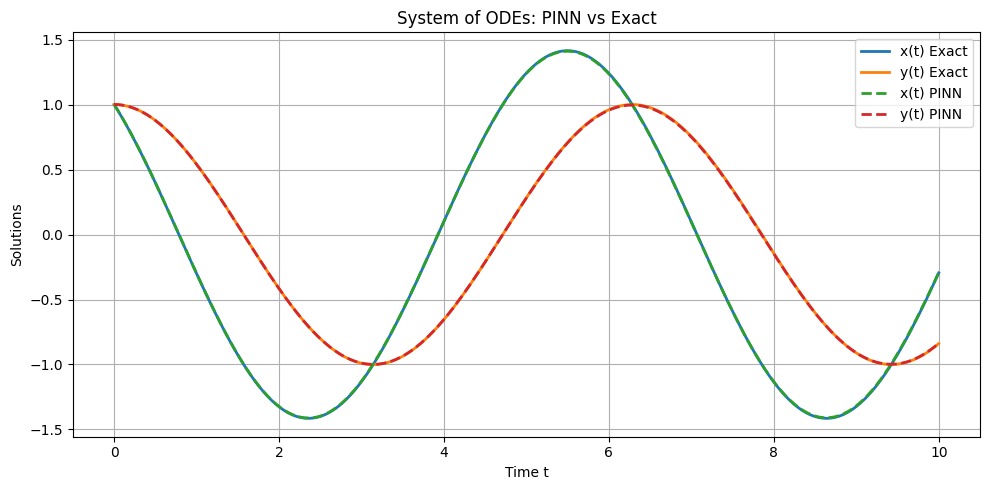

In [12]:
# Evaluation
t_eval = np.linspace(0, 10, 200).reshape(-1, 1)
t_eval_tf = tf.convert_to_tensor(t_eval, dtype=tf.float64)
xy_pred = model(t_eval_tf).numpy()
x_pred, y_pred = xy_pred[:, 0], xy_pred[:, 1]

# Exact solution
x_exact = np.cos(t_eval[:, 0]) - np.sin(t_eval[:, 0])
y_exact = np.cos(t_eval[:, 0])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t_eval, x_exact, label="x(t) Exact", linewidth=2)
plt.plot(t_eval, y_exact, label="y(t) Exact", linewidth=2)
plt.plot(t_eval, x_pred, '--', label="x(t) PINN", linewidth=2)
plt.plot(t_eval, y_pred, '--', label="y(t) PINN", linewidth=2)
plt.xlabel("Time t")
plt.ylabel("Solutions")
plt.title("System of ODEs: PINN vs Exact")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Results**

The plot shows perfect overlap between:

- Exact solutions $x(t)$, $y(t)$

- Predicted solutions $\hat{x}(t)$, $\hat{y}(t)$

This confirms that the PINN learned to satisfy both the differential equations and the initial condition — without needing labeled data, only physics!